# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- <b>Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?</b><br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Preprocessing

In [4]:
total_passes_counts = pd.DataFrame()
total_goals_passes_counts = pd.DataFrame()
total_comparison = pd.DataFrame()

In [5]:
for events in events_df.values():
    events['tags'] = events['tags'].apply(extract_tags)

In football, a "pass chain" typically refers to a sequence of passes made by players of a team during a particular play or possession. It's a way to describe the flow of ball movement through passing within the team.<br>
However, this definition can be subjective. If an opponent touches the ball, is the pass chain interrupted? If there is a duel but the team who had the ball possession keeps the ball, is that considered the beginning of a new pass chain or not? As a personal interpretation of this argument, when the mentioned events happen, the pass chain continues, and that is why the next plots represent two analyses: the first one considering the totality of the events, the second one removing all the duels and touches from the dataset.

All the plots have a power law distribution, meaning that the shots and goals are mainly made after a short pass chain, as a result of a penalty kick, a corner, a ball recovery of a player that makes a personal action or gives an assist to another player that, next, makes a shot. However, some changes among different competitions are supposed to be noticed, for example in La Liga, where the teams usually have a high ball possession and make a high number of passes.

In [6]:
def pass_chain_analysis(competition_area, competition_name):
    competition_events = events_df[competition_area]

    # returns a dictionary with the number of passes before a shot for each match and each event
    passes_before_shot = get_passes_before_shot(competition_events)
    # returns a dataframe with the number of passes before a shot for each match
    competition_passes_counts = count_passes_before_shot(passes_before_shot)
    # add a column to the dataframe to specify if the event is a duel or not in order to make the comparison
    competition_passes_counts['duel'] = True

    # returns a dataframe with the number of passes before a goal for each match
    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    # retrieves only the goals caused by a shot
    goals = goals[goals['subEventName'] == 'Shot']

    # retrieves, from the previous dictionary, the number of passes before a goal for each match
    passes_before_goal = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        
        passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

    # returns a dataframe with the number of passes before a goal for each match
    competition_goals_passes_counts = count_passes_before_shot(passes_before_goal)
    competition_goals_passes_counts['duel'] = True

    # this part is the same as the previous computation but removing the duels (specifically, all the events with eventId equal to 1
    # and subEventId equal to 11, 12 or 13)

    competition_events = competition_events[((competition_events['eventId'] != 1) & (~competition_events['subEventId'].isin([11, 12, 13])))].reset_index(drop=True)
    competition_events = competition_events[((competition_events['eventId'] != 7) & (competition_events['subEventId'] != 72))].reset_index(drop=True)

    passes_before_shot_no_duel = get_passes_before_shot(competition_events)
    competition_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

    competition_passes_counts_no_duels['duel'] = False

    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    goals = goals[goals['subEventName'] == 'Shot']

    passes_before_goal_no_duel = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        
        passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

    competition_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
    competition_goals_passes_counts_no_duels['duel'] = False
    
    competition_passes_counts = pd.concat([competition_passes_counts, competition_passes_counts_no_duels])
    competition_goals_passes_counts = pd.concat([competition_goals_passes_counts, competition_goals_passes_counts_no_duels])

    competition_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels['Goal'] = True

    comparison_goals_passes_counts = pd.concat([competition_passes_counts_no_duels, competition_goals_passes_counts_no_duels])

    # plots
    plot_histogram_pass_chain(competition_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in the %s' %competition_name)
    plot_histogram_pass_chain(competition_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in the %s' %competition_name)
    plot_histogram_comparison_pass_chain(comparison_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in the %s (with no duels)' %competition_name)

    #update the total dataframes
    return competition_passes_counts, competition_goals_passes_counts, comparison_goals_passes_counts

In [7]:
def total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison):
    total_passes_counts = total_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_goals_passes_counts = total_goals_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_comparison = total_comparison.groupby(['Passes', 'Goal'])['count'].sum().to_frame().reset_index()
    
    plot_histogram_pass_chain(total_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in all the competitions')
    plot_histogram_pass_chain(total_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in all the competitions')
    plot_histogram_comparison_pass_chain(total_comparison, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in all the competitions')

### Italian pass chains analysis

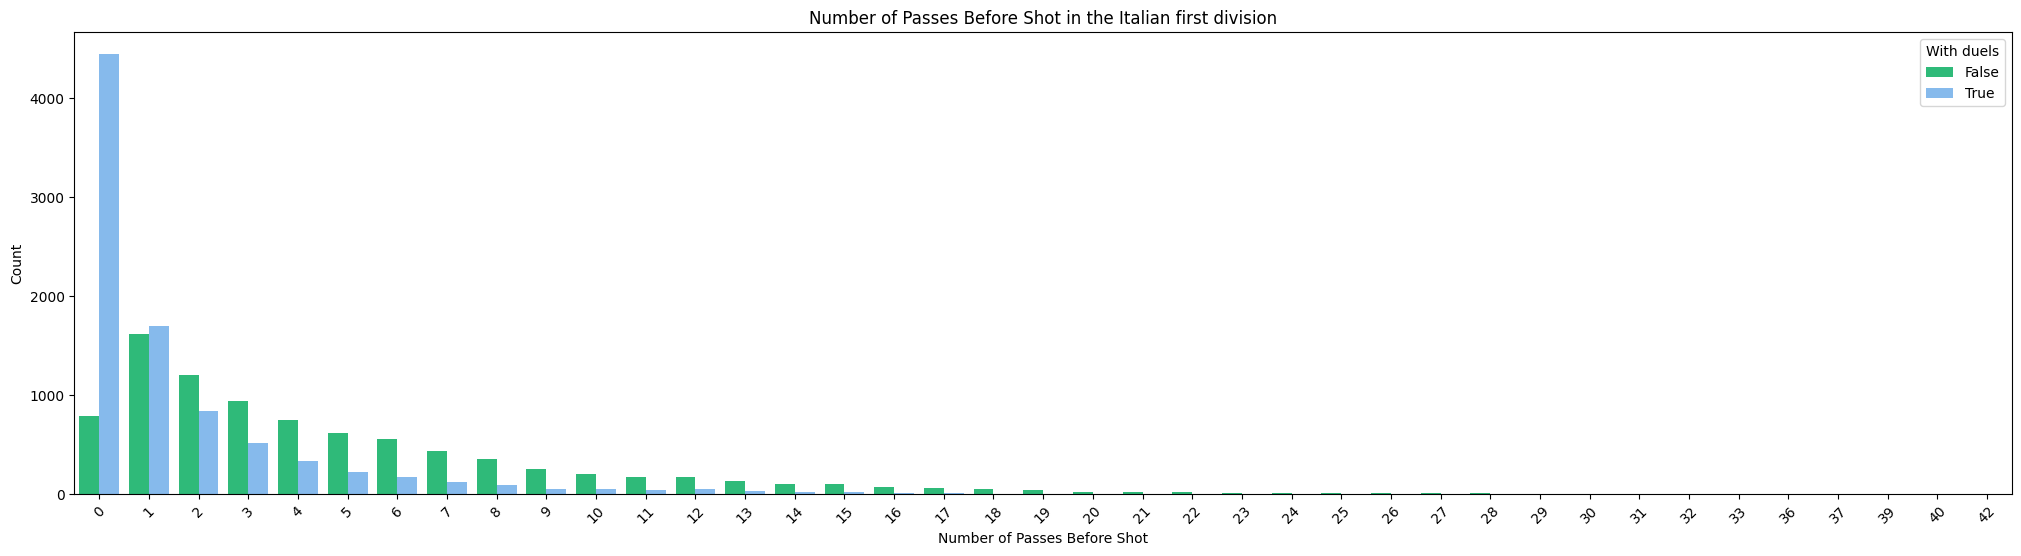

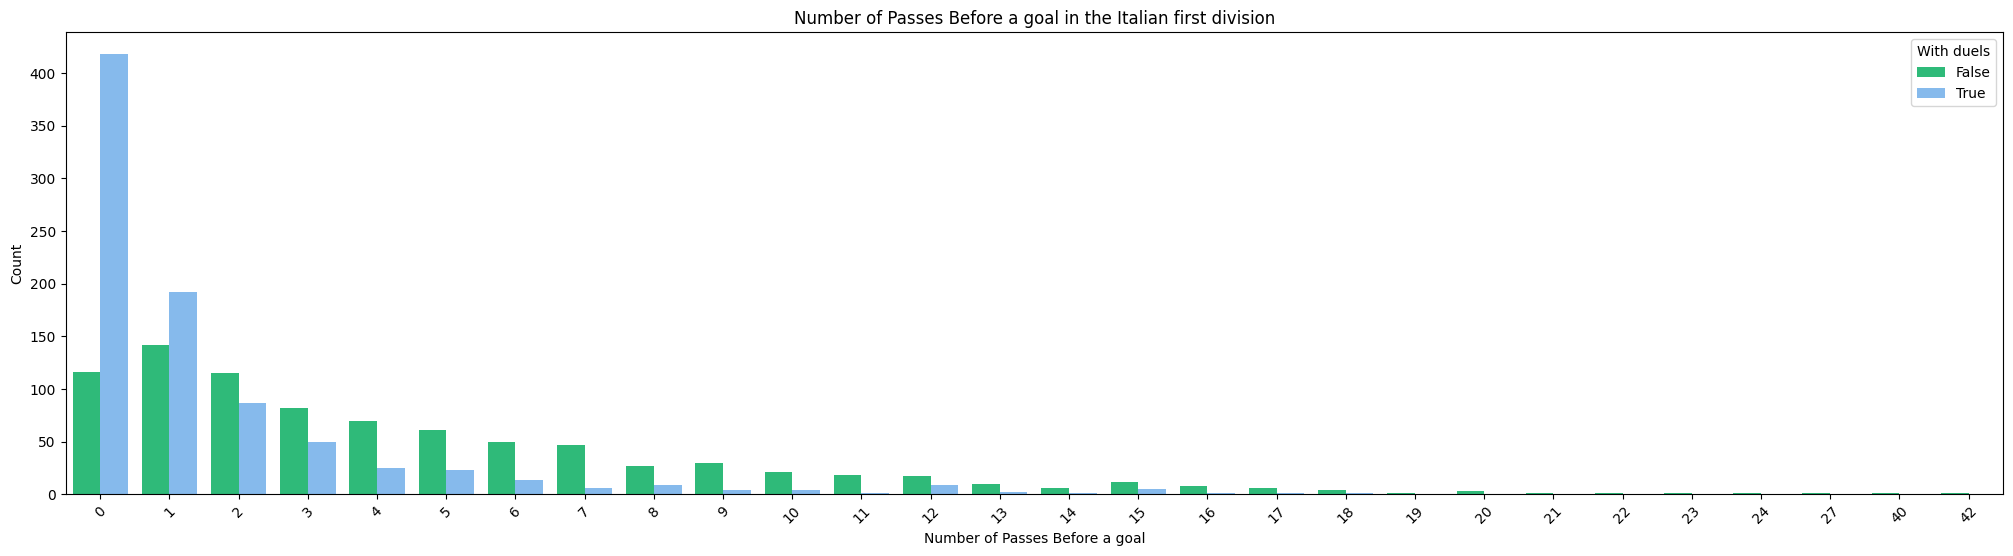

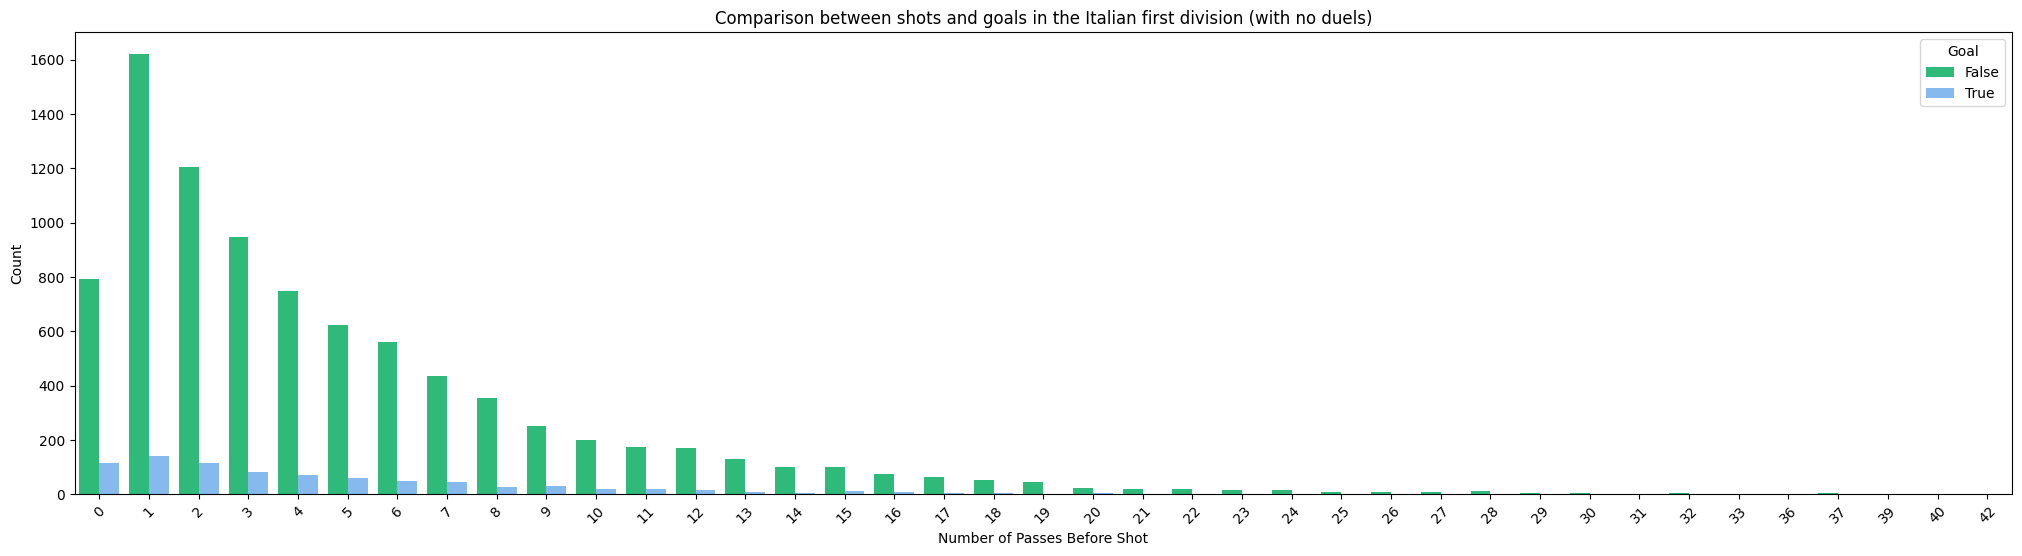

In [8]:
df1, df2, df3 = pass_chain_analysis('Italy', 'Italian first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### English pass chains analysis

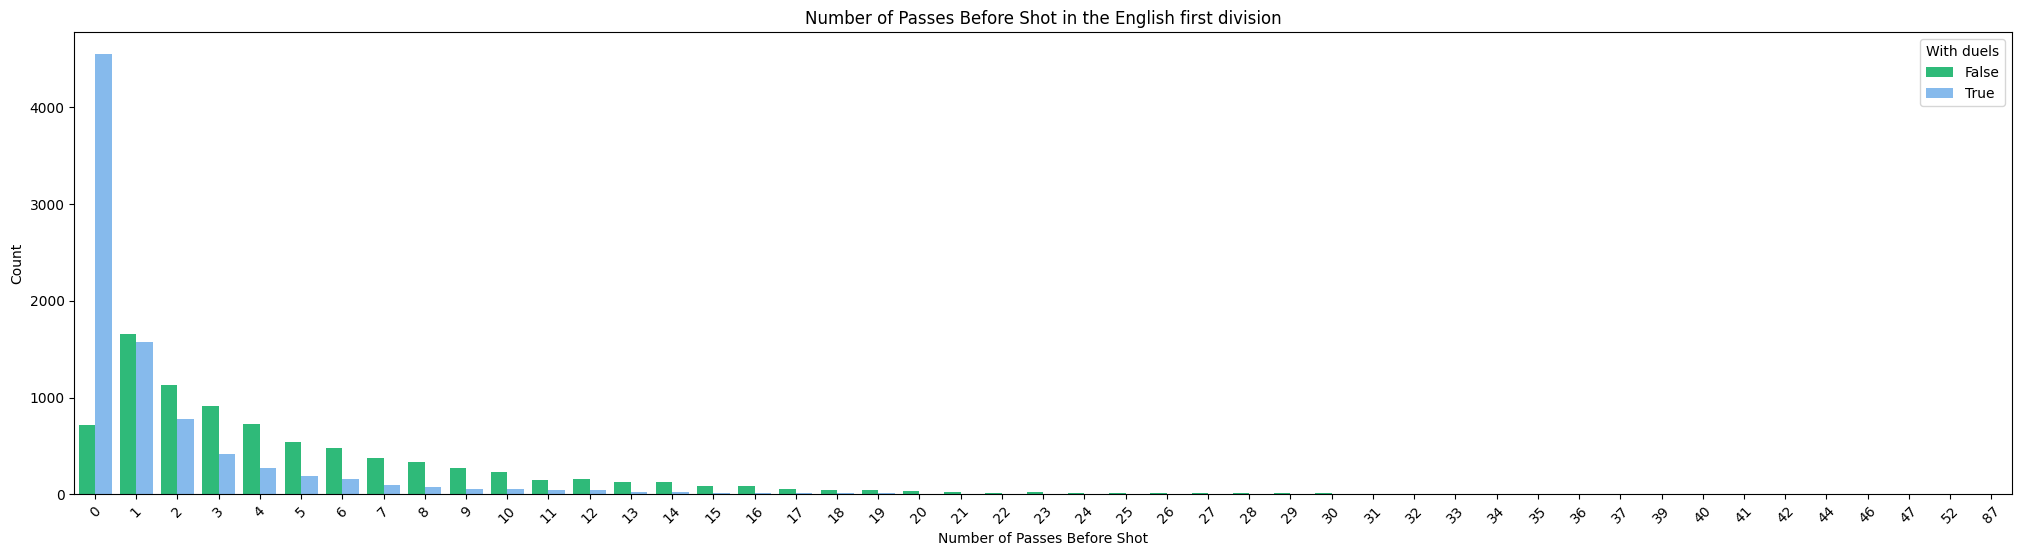

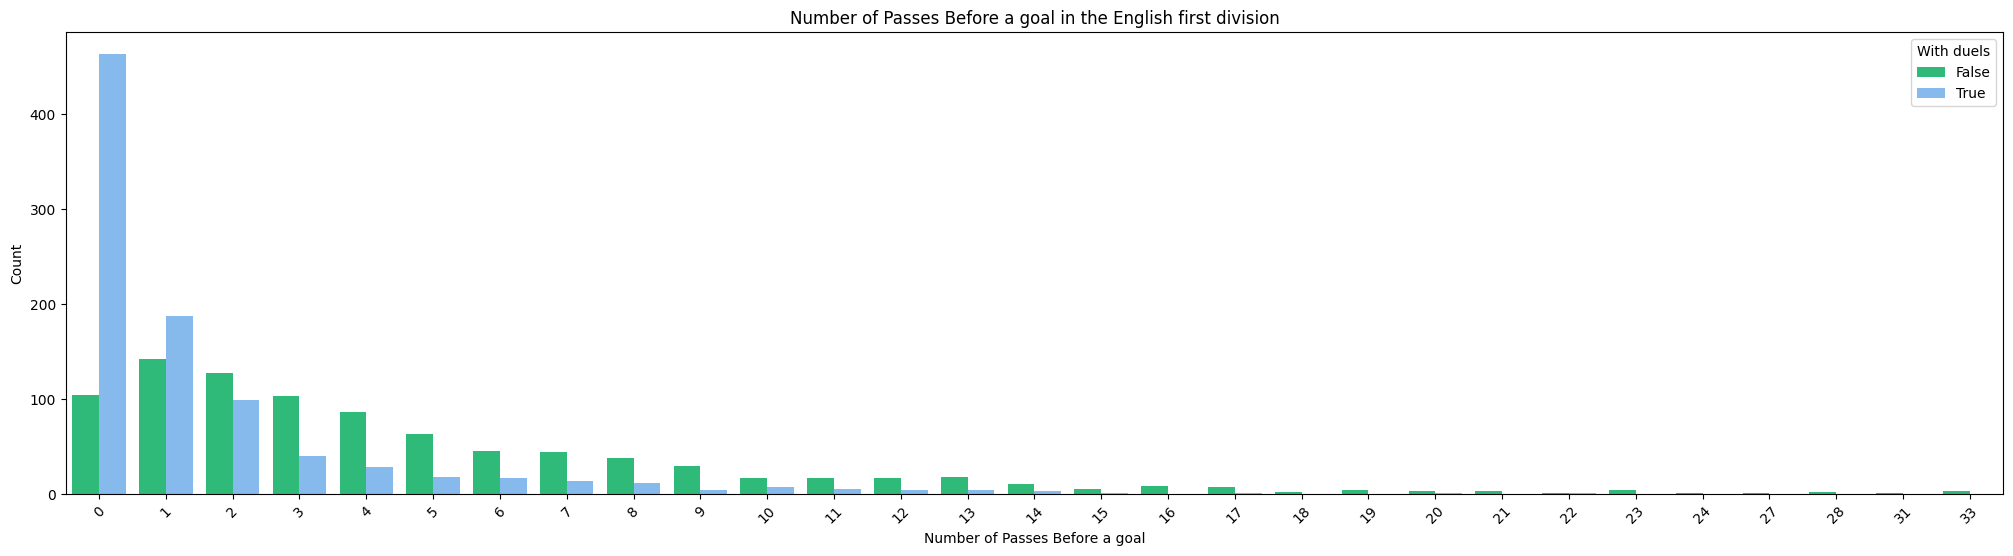

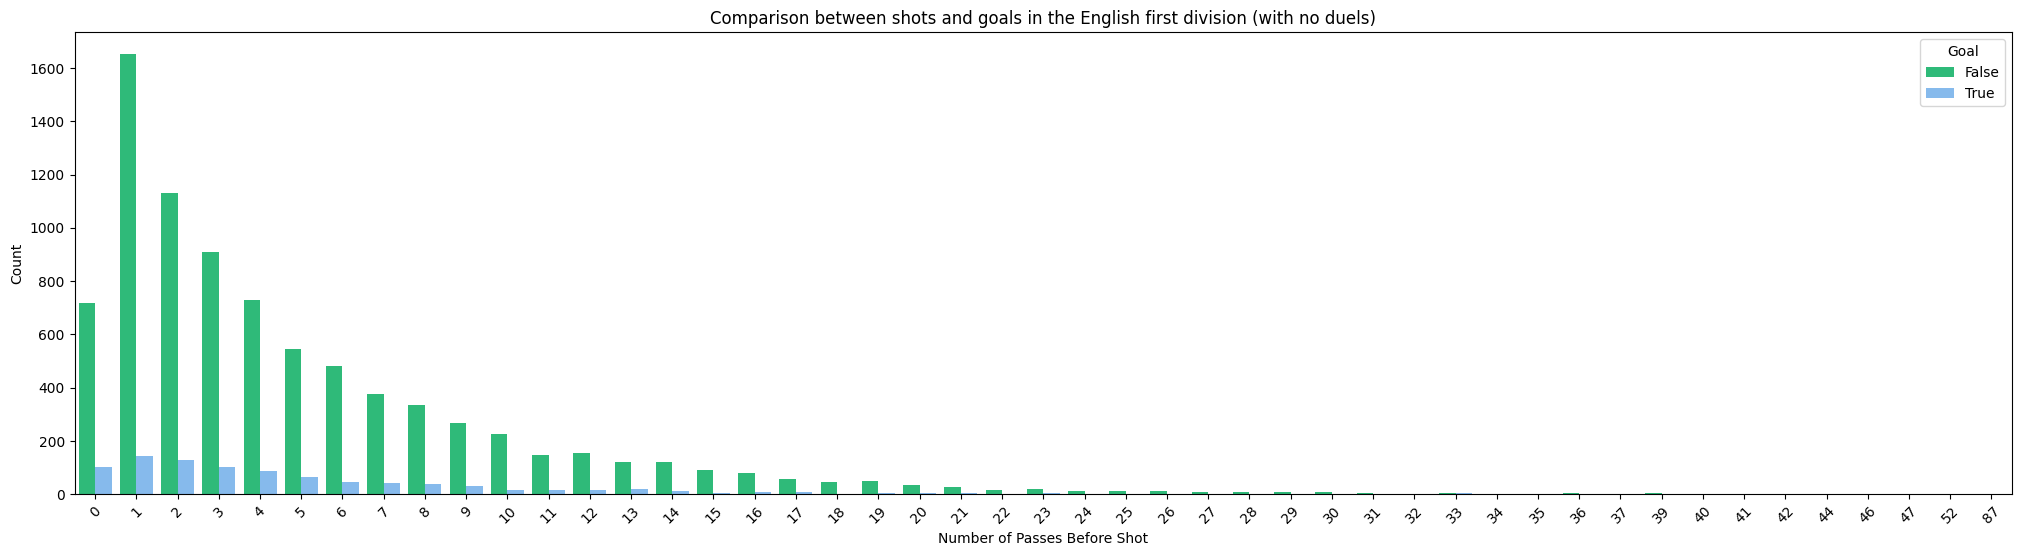

In [9]:
df1, df2, df3 = pass_chain_analysis('England', 'English first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### Spanish pass chain analysis

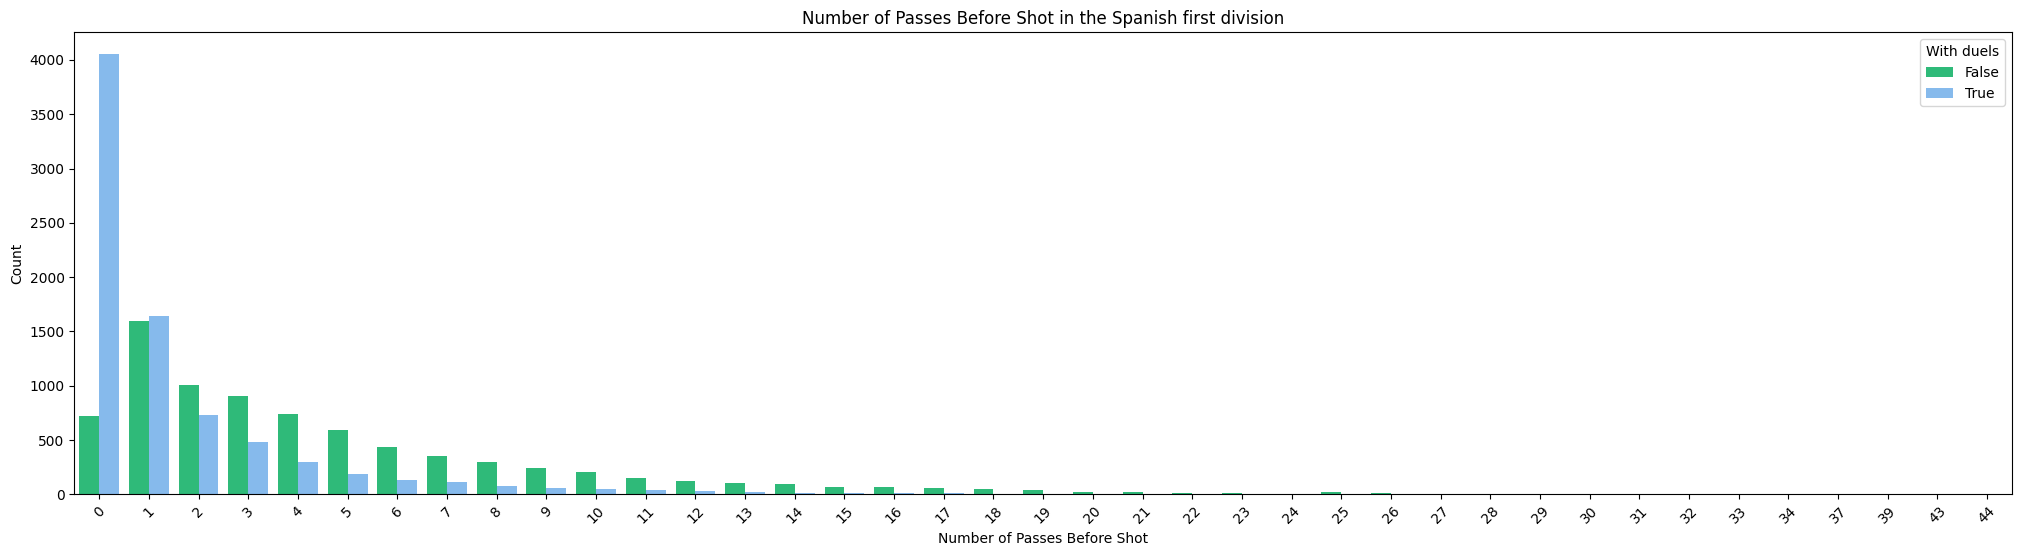

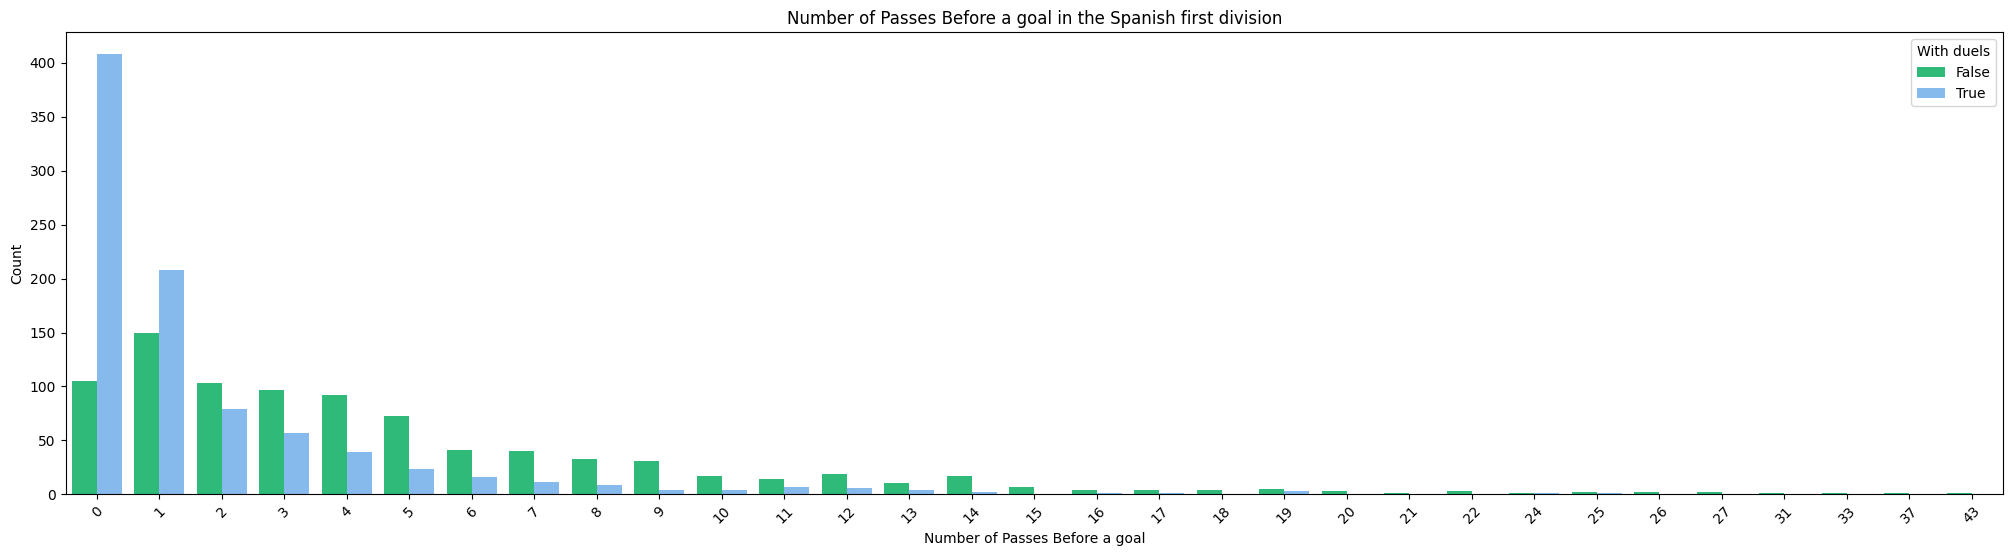

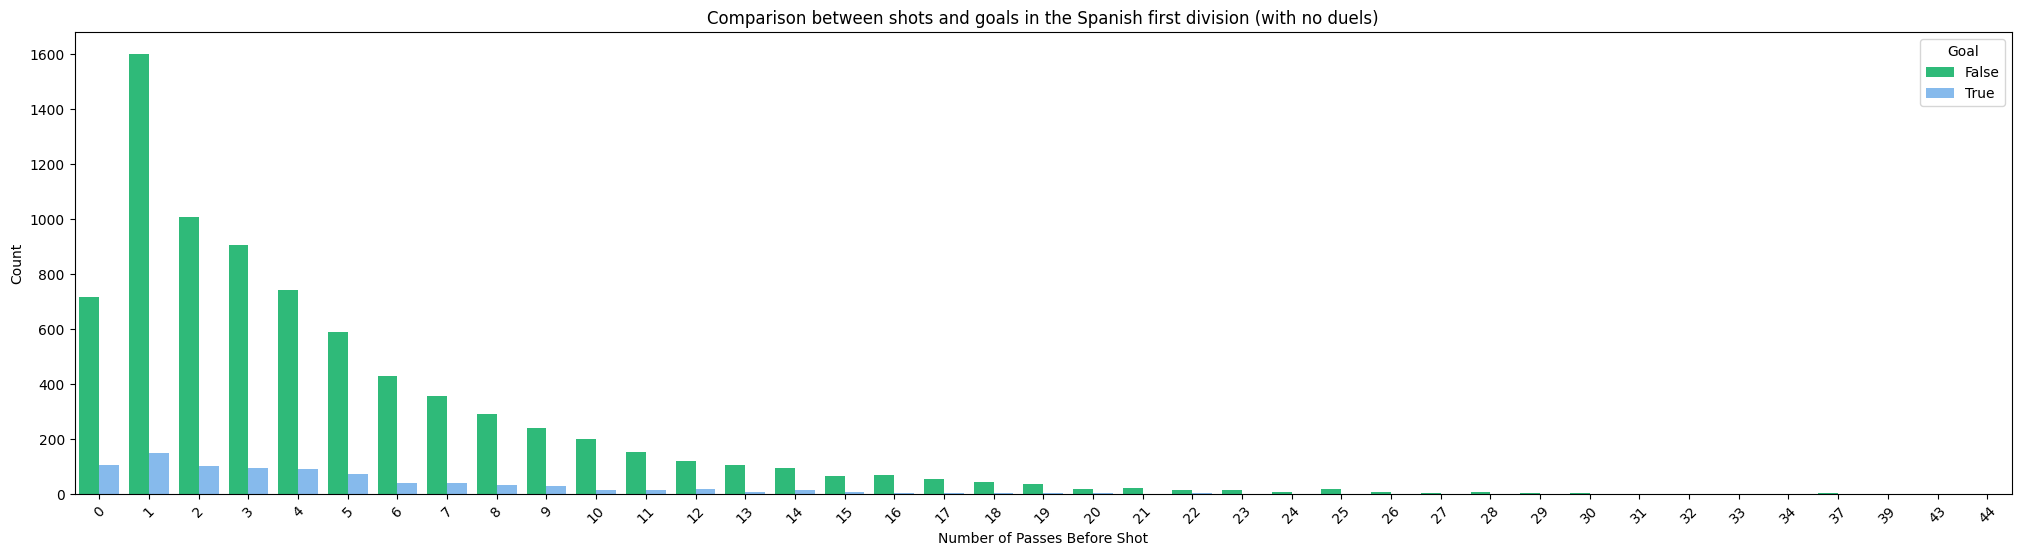

In [10]:
df1, df2, df3 = pass_chain_analysis('Spain', 'Spanish first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### German pass chain analysis

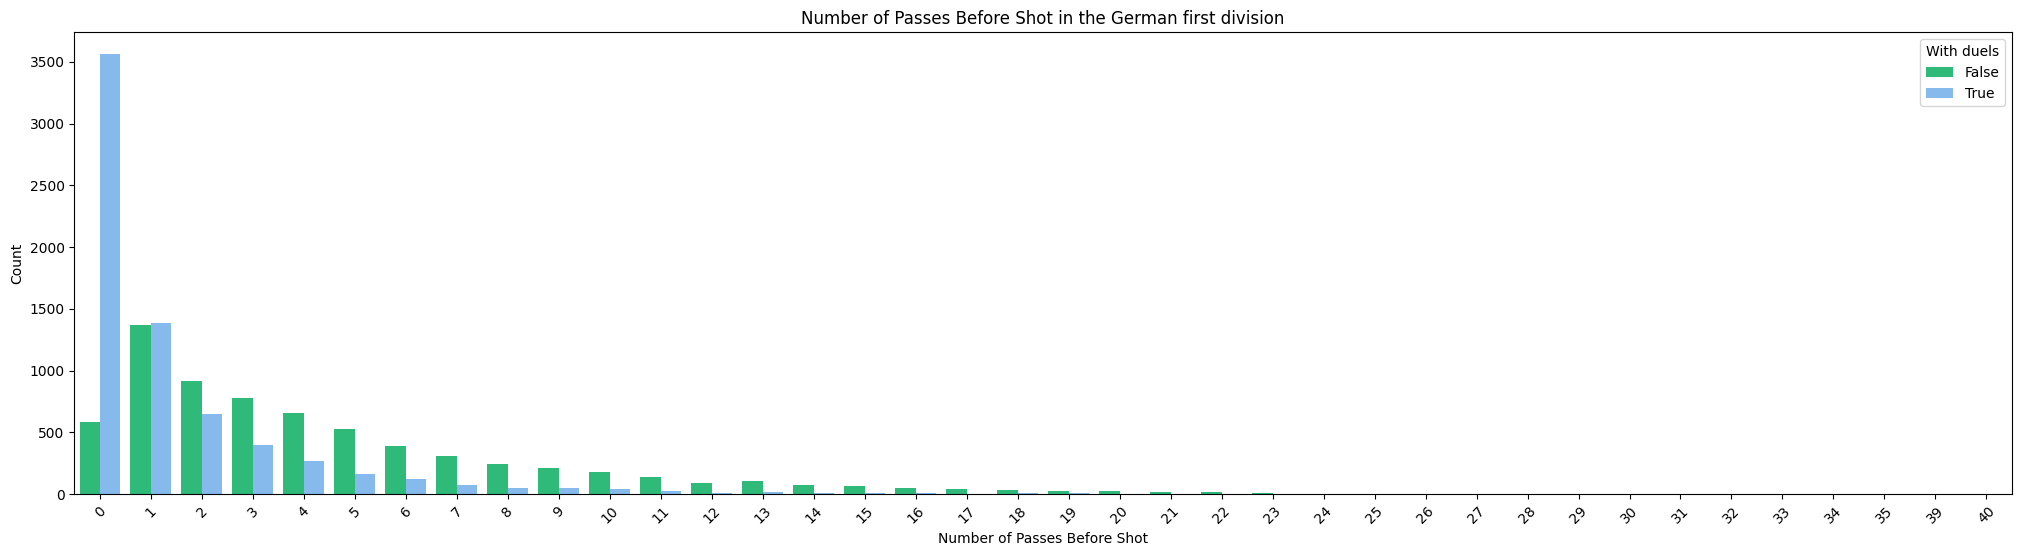

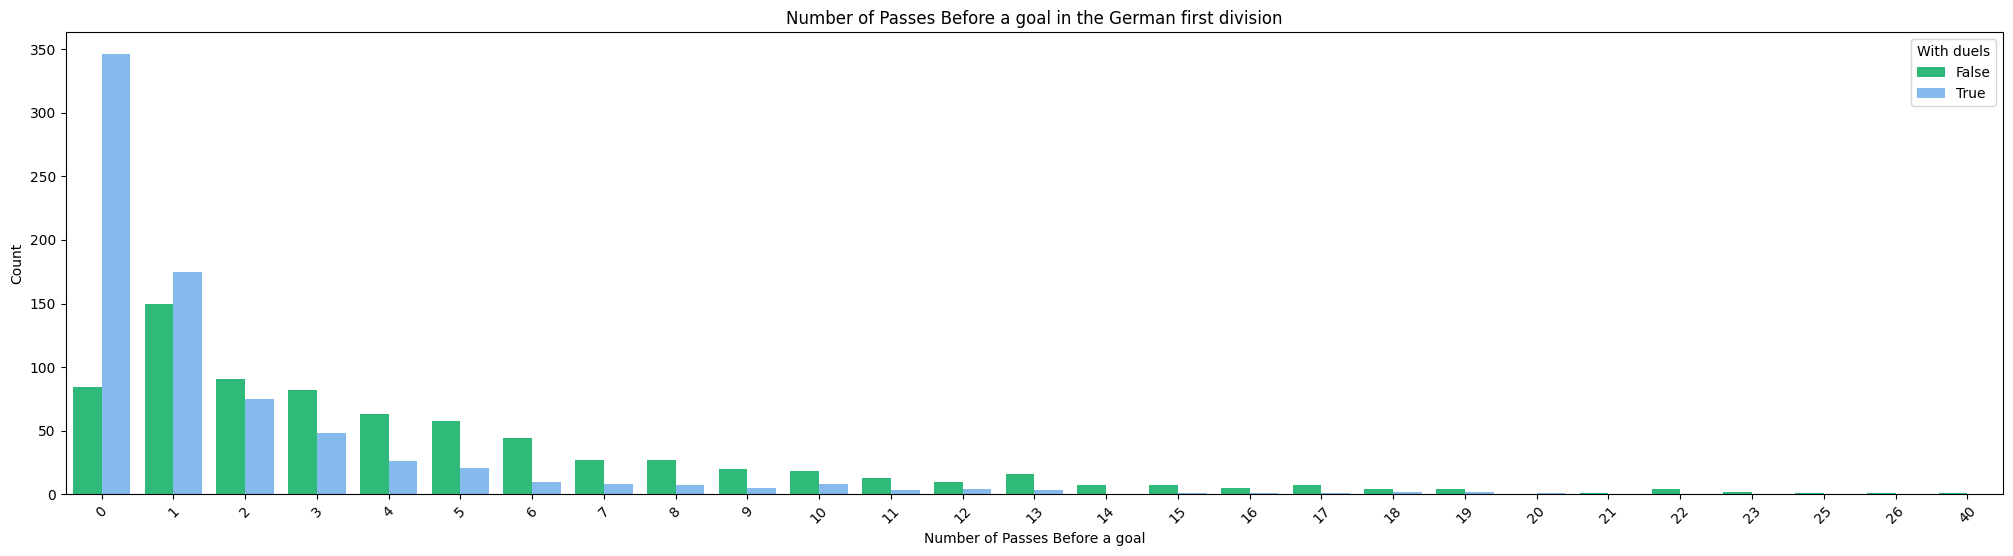

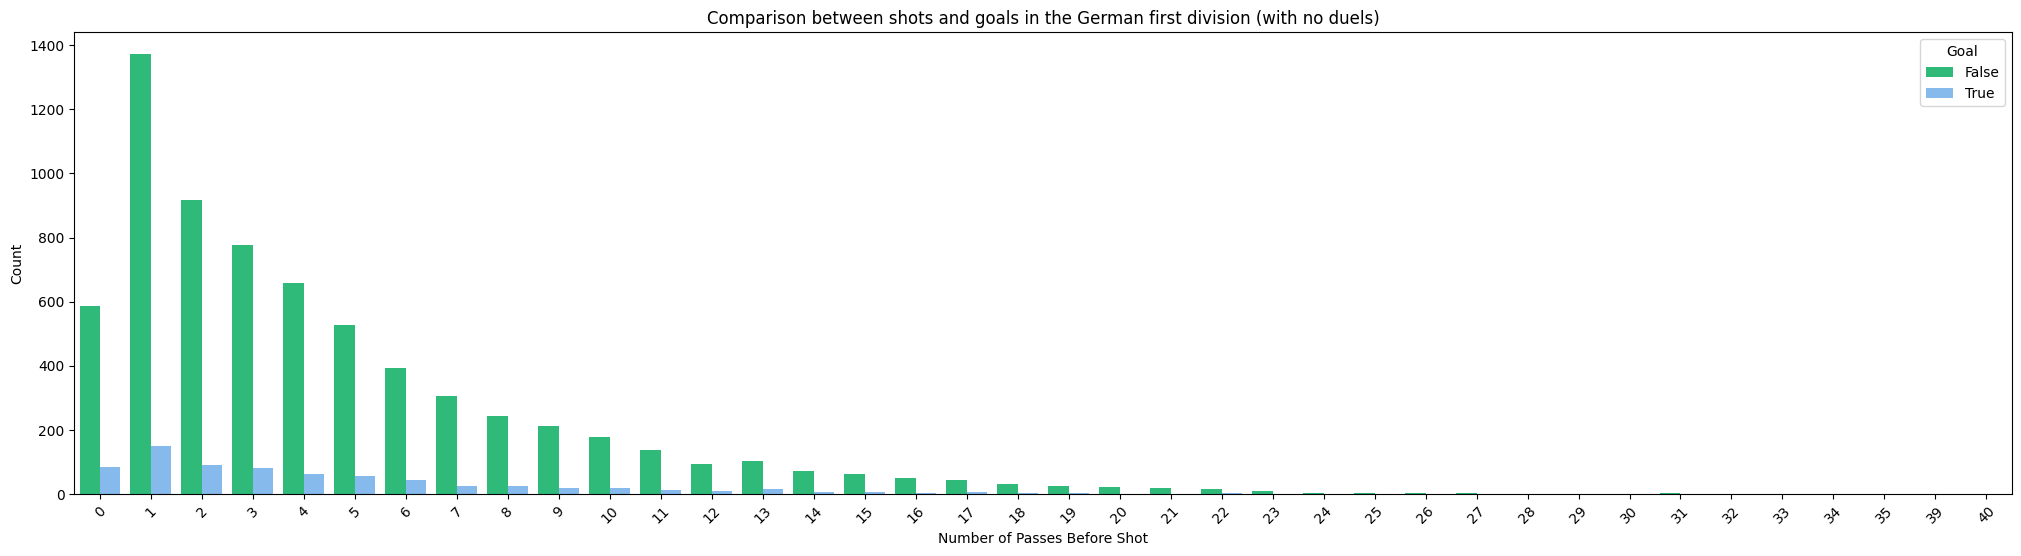

In [11]:
df1, df2, df3 = pass_chain_analysis('Germany', 'German first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### French pass chain analysis

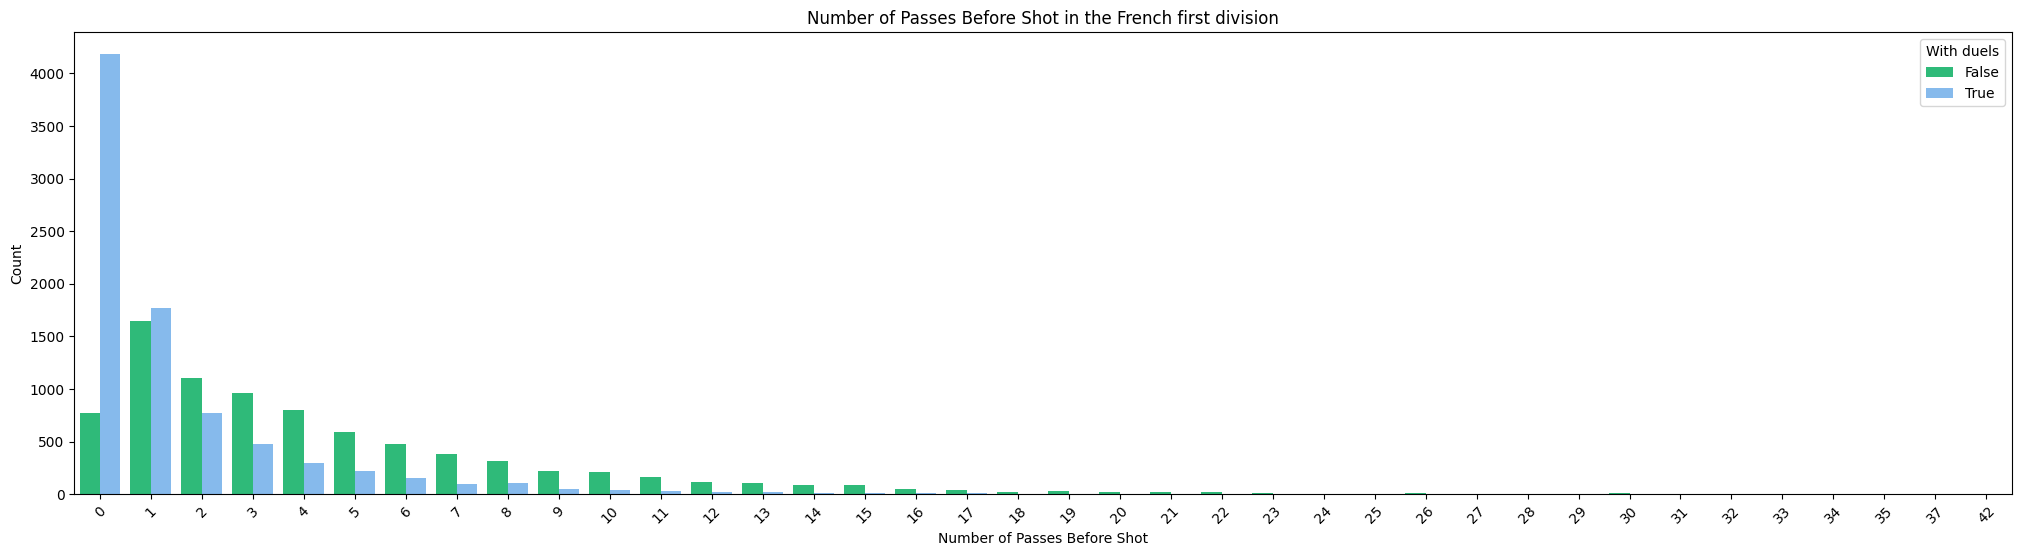

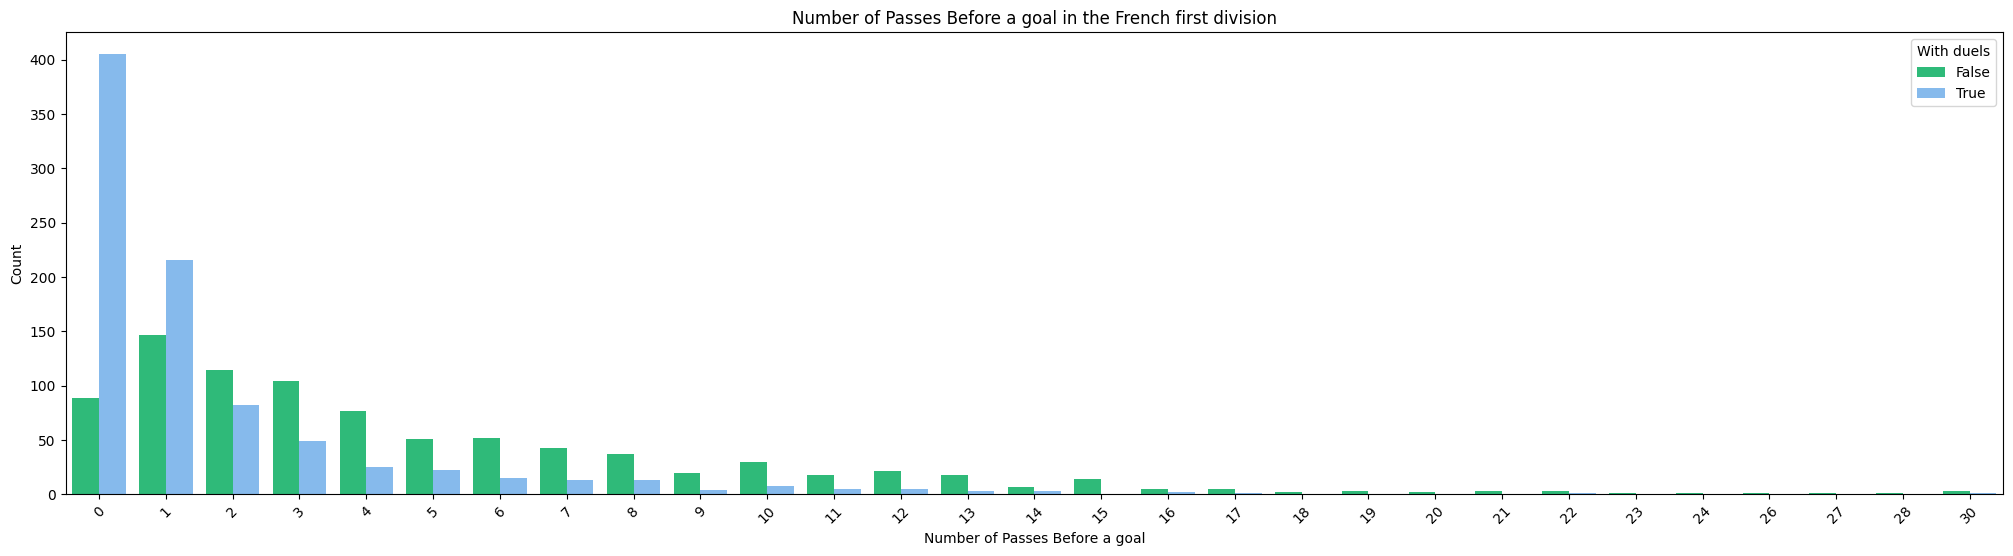

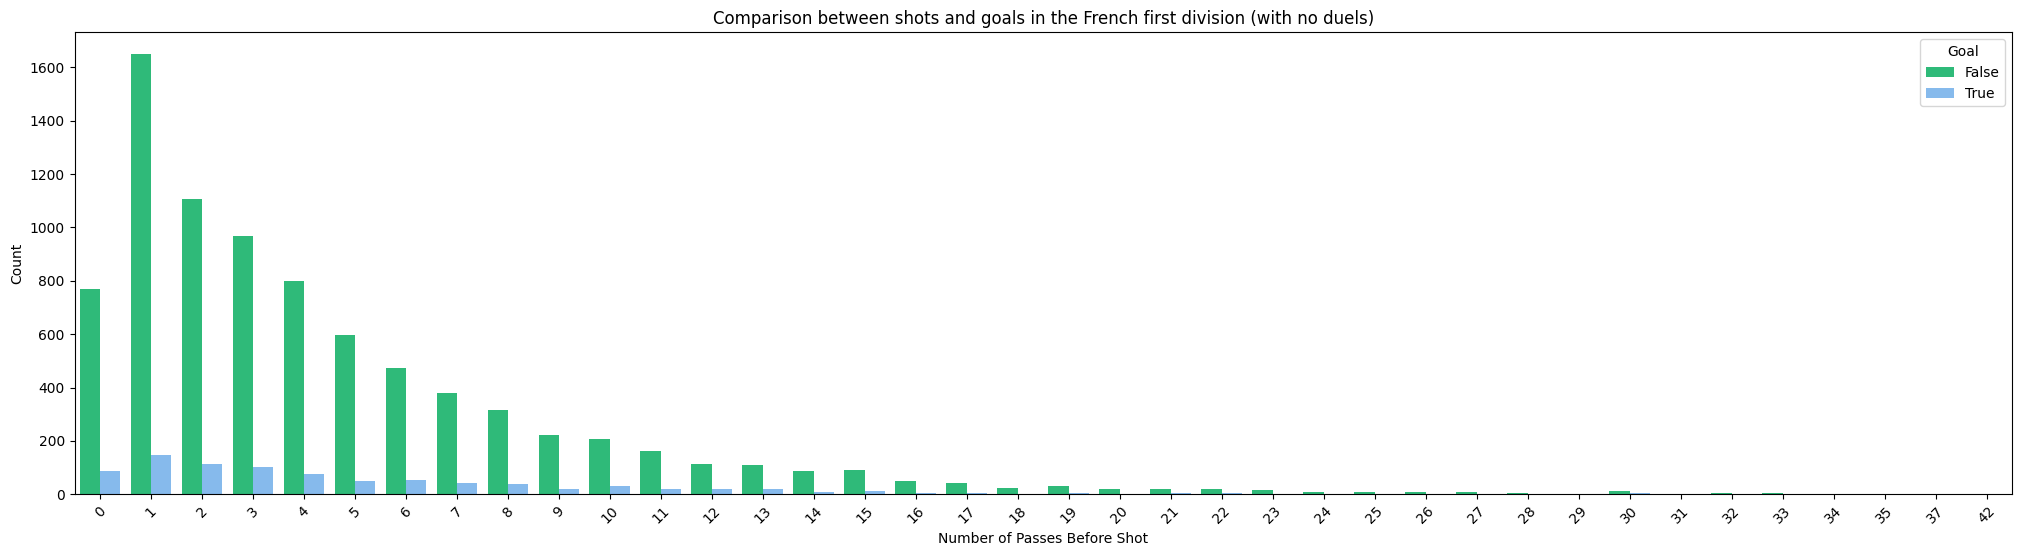

In [12]:
df1, df2, df3 = pass_chain_analysis('France', 'French first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### European Championship pass chain analysis

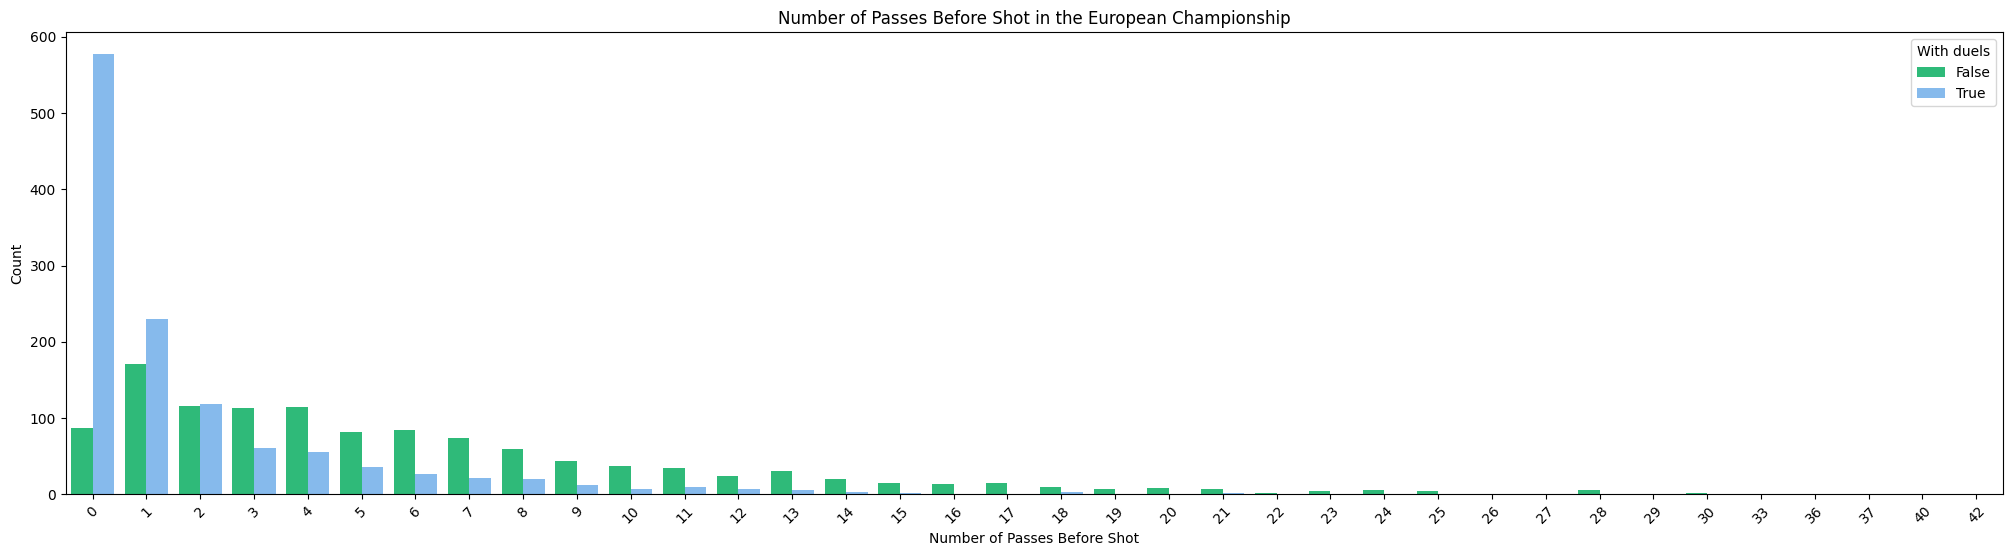

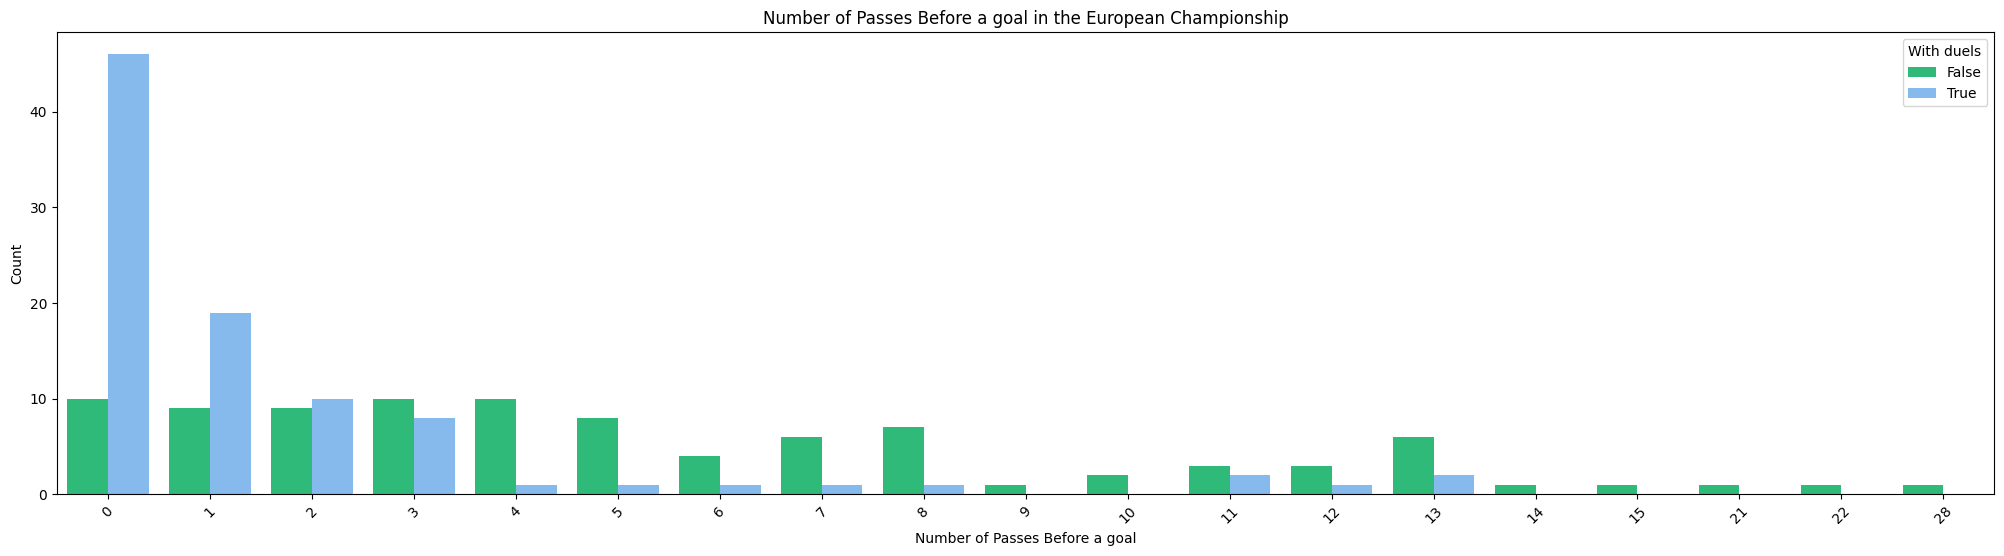

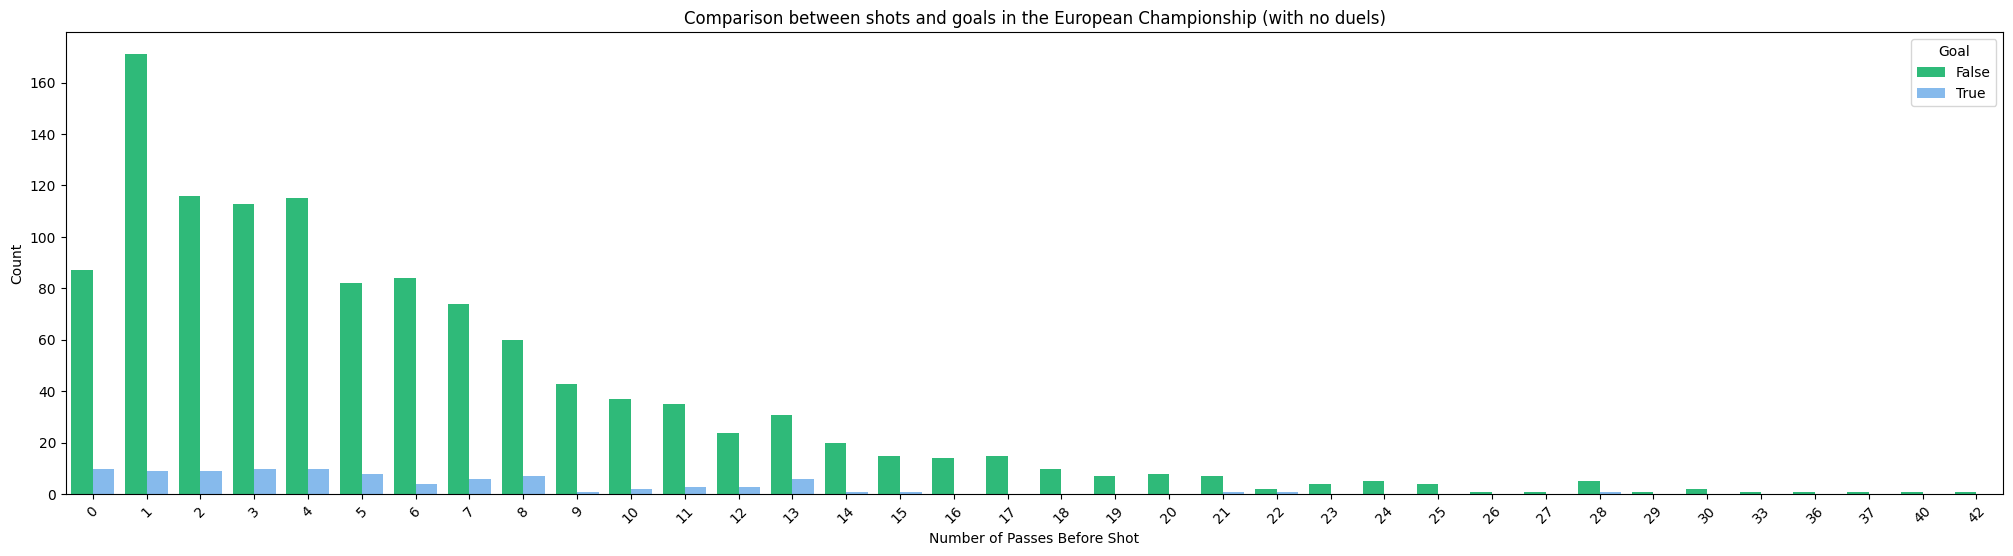

In [13]:
df1, df2, df3 = pass_chain_analysis('European_Championship', 'European Championship')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### World Cup pass chain analysis

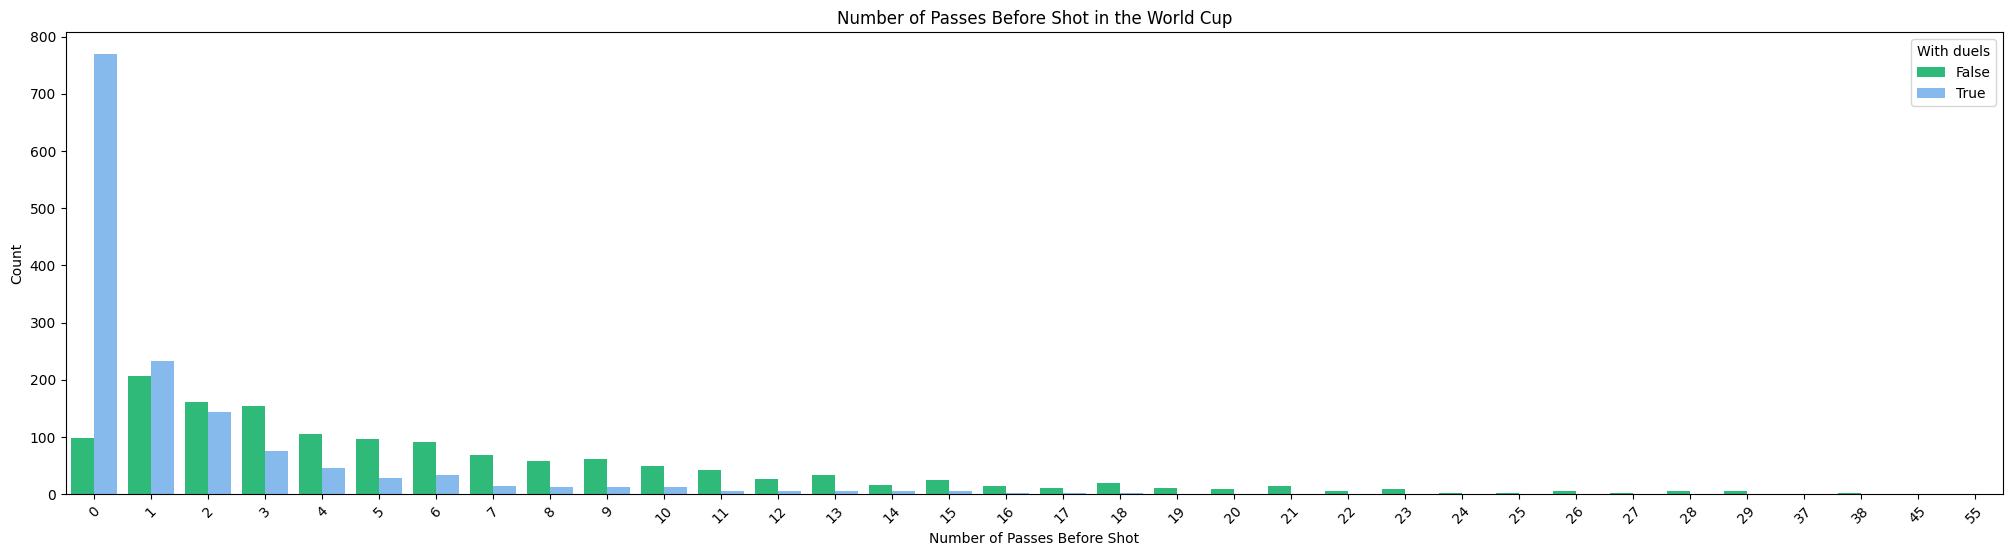

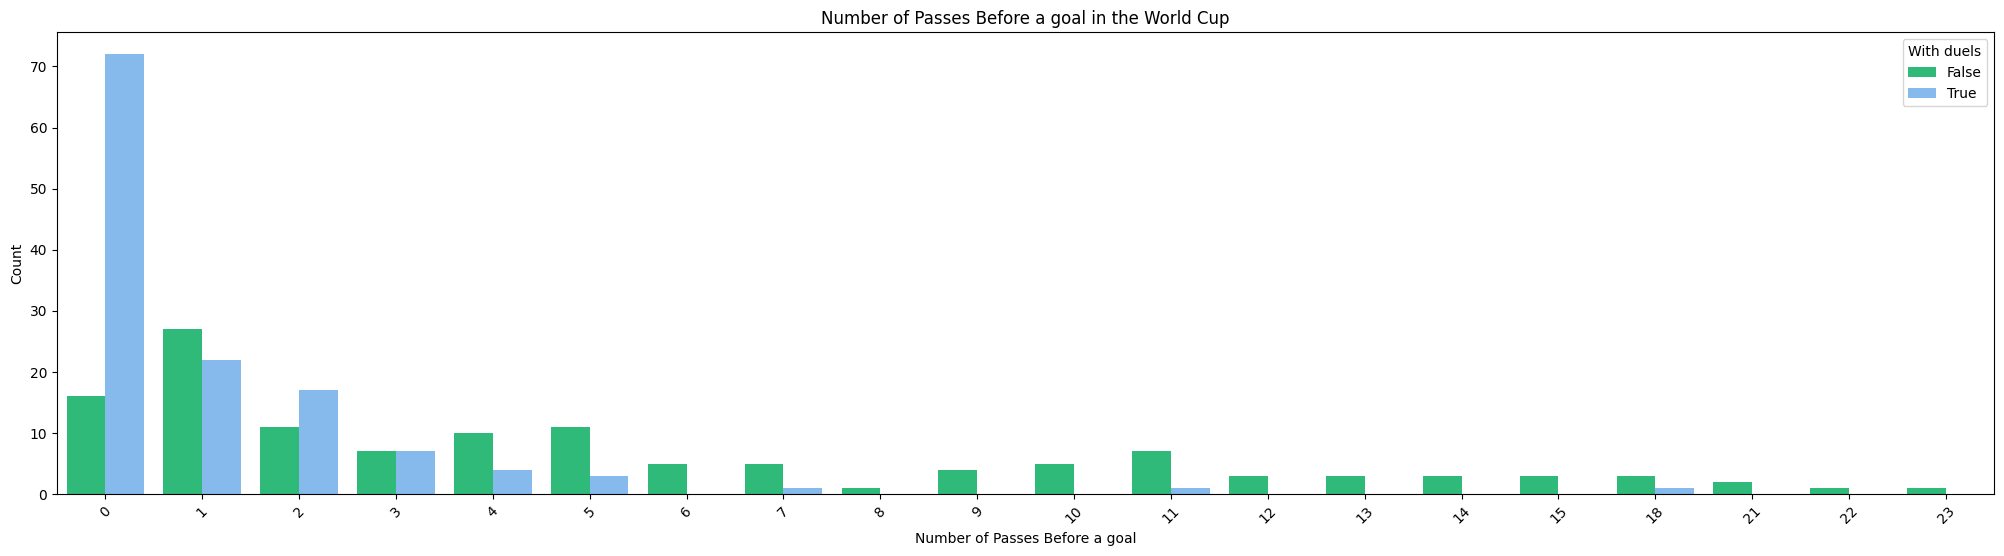

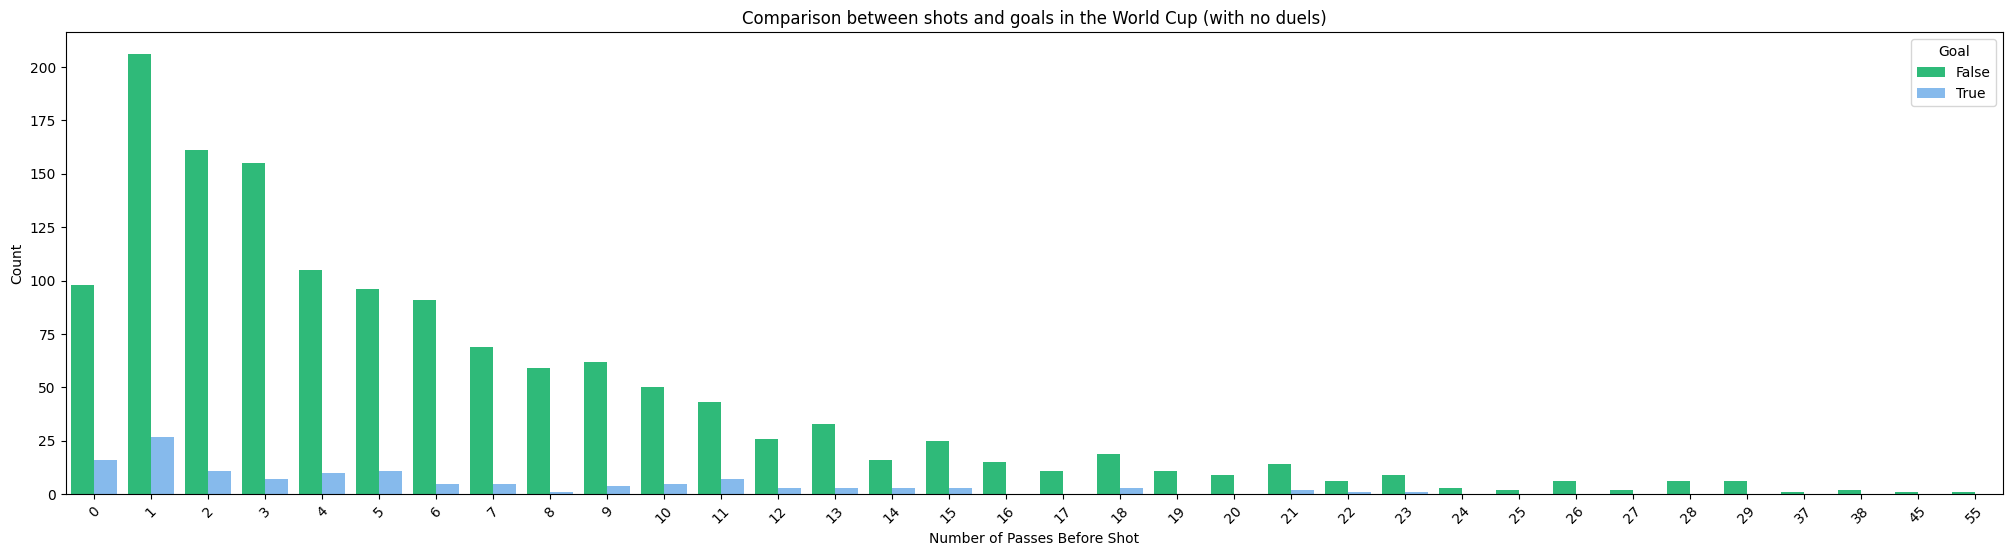

In [14]:
df1, df2, df3 = pass_chain_analysis('World_Cup', 'World Cup')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### Total analysis

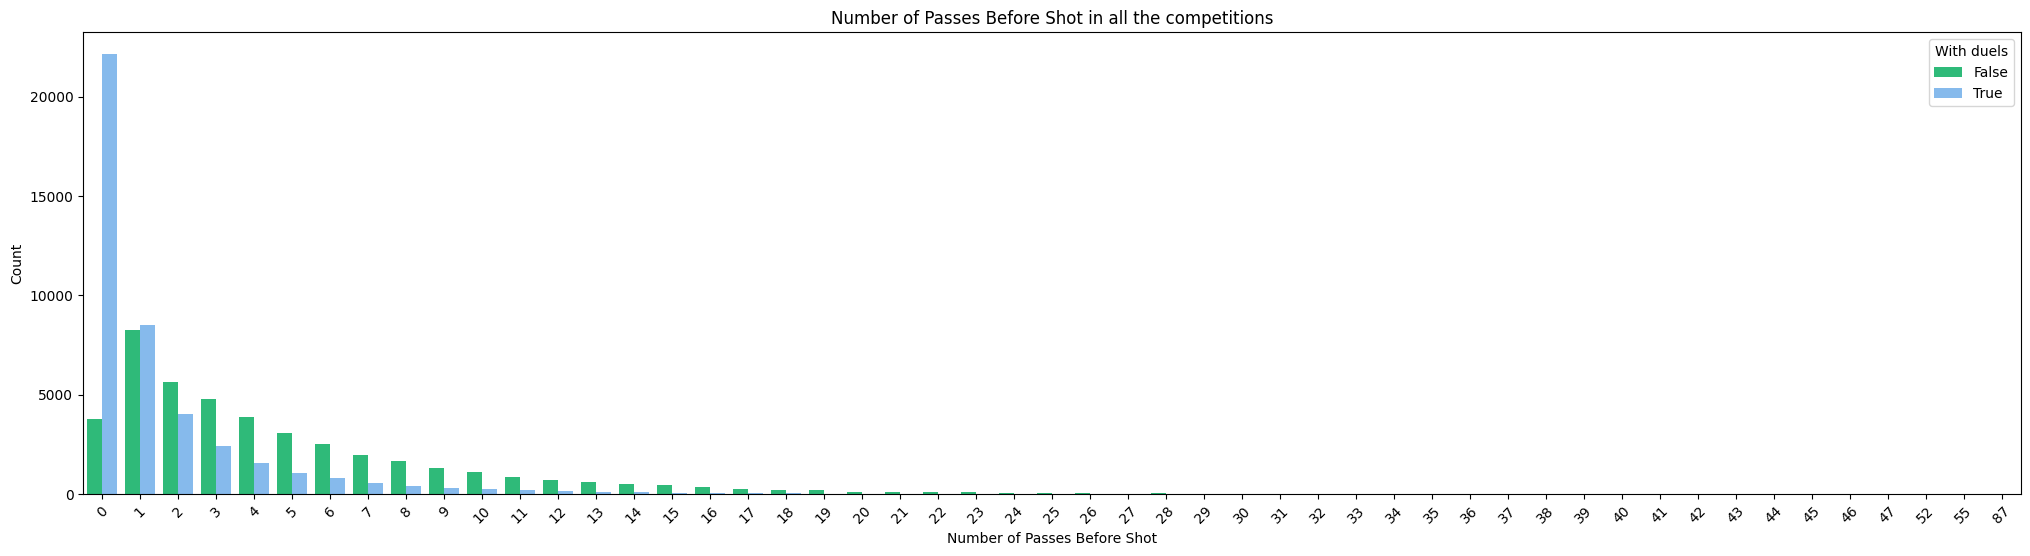

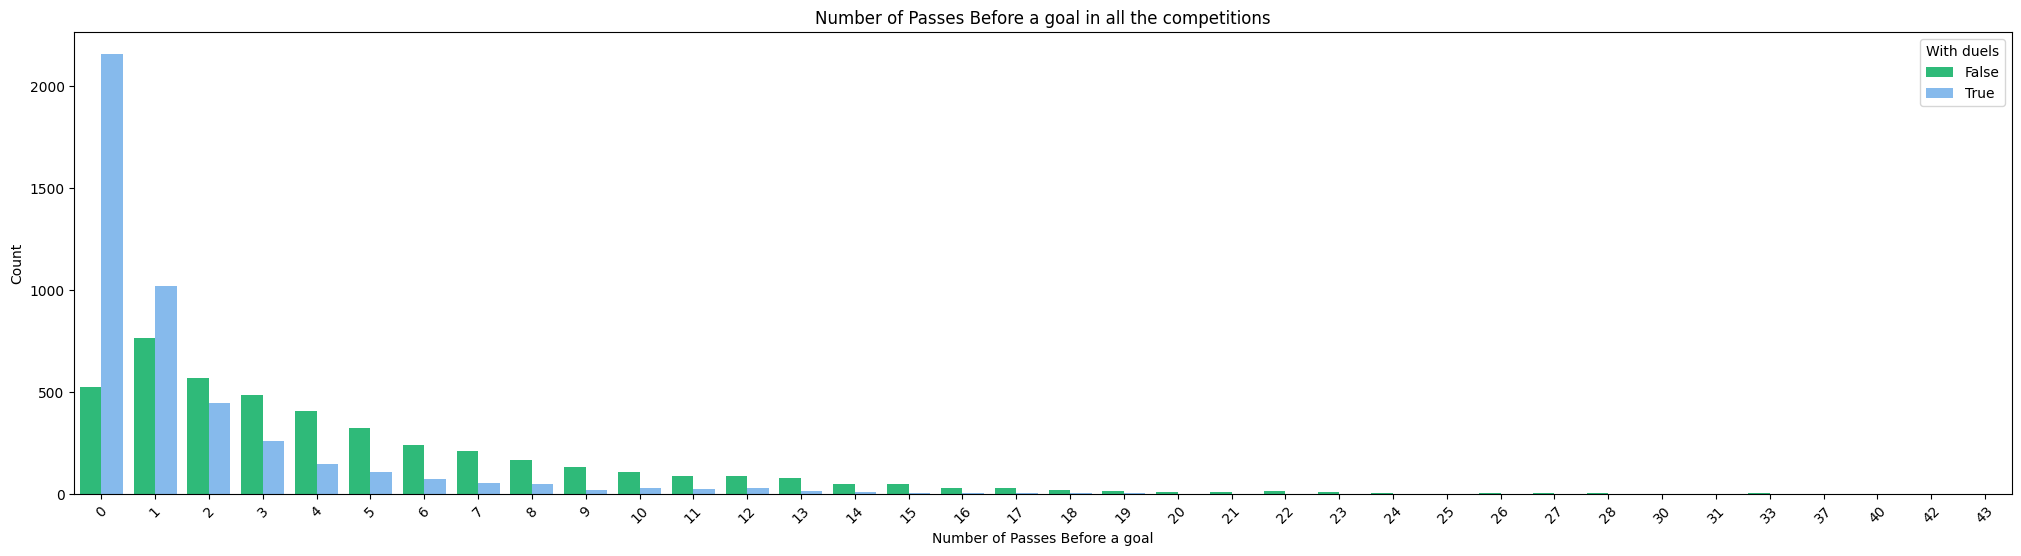

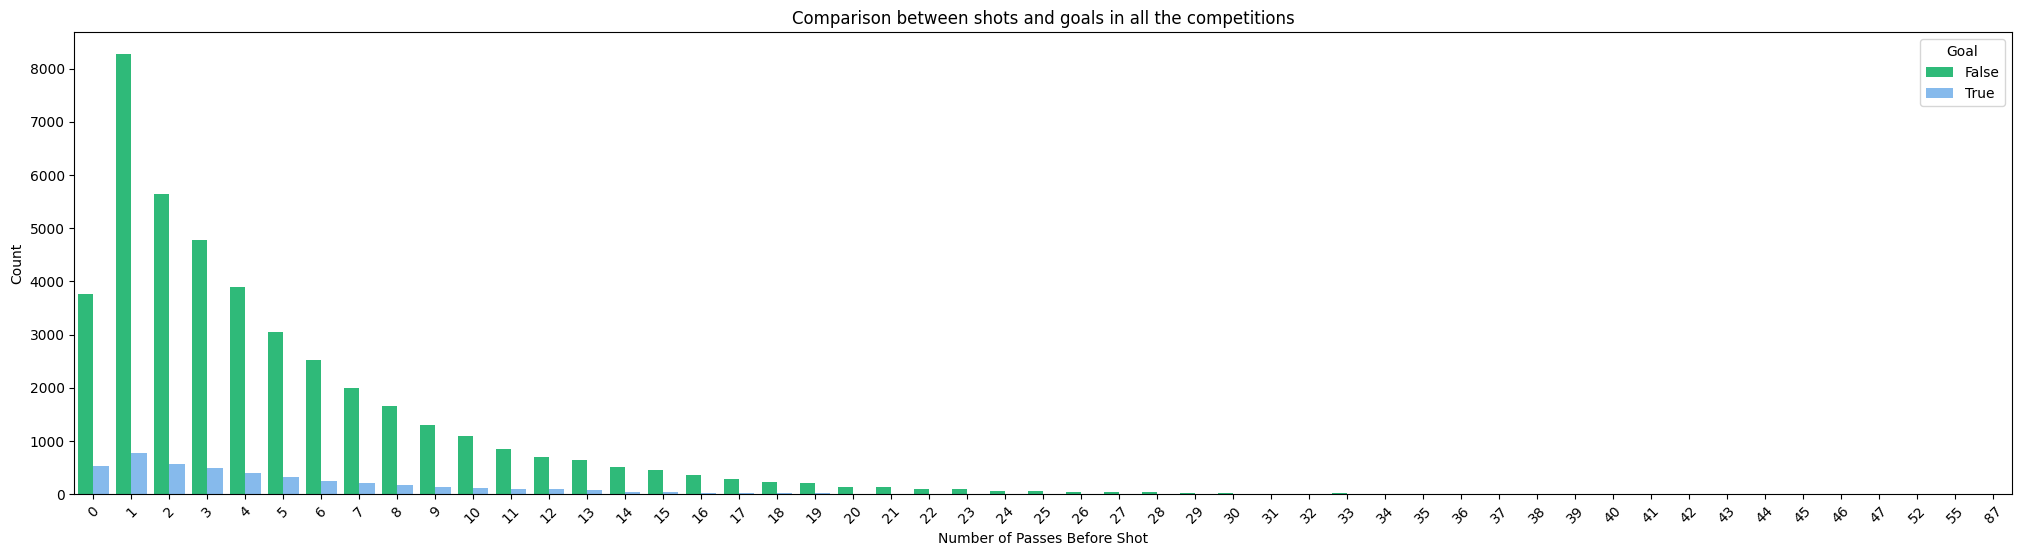

In [15]:
total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison)